# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

In [2]:
import os
import h5py
import numpy as np
import time

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count
from IPython.display import Image

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3892431276610544449
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7857467800226141957
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12816477229496294348
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13919205018513852775
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 11958968751072547984
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memor

In [4]:
PROTEIN="5j0n"#"5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [5]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


### True Angles

In [6]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

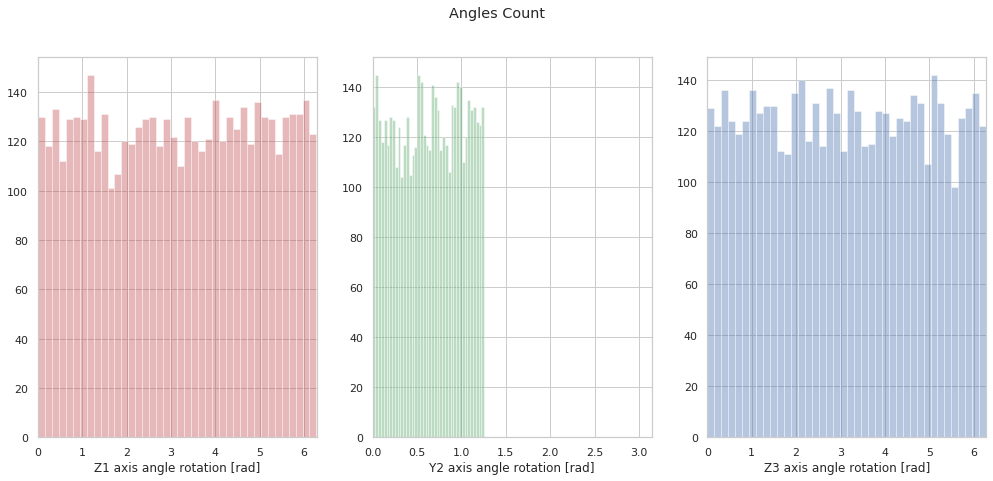

In [7]:
plot_angles_count(angles_true)

---

## Prepare for training

In [8]:
from sklearn.model_selection import train_test_split
from cryoem.distance_estimation import create_pairs

In [9]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

In [10]:
X_max_px = np.max(X)
X = X/X_max_px
print(f"Projection images will be normalized to have pixels ranging from 0 to 1 instead of 1 to {X_max_px}")

Projection images will be normalized to have pixels ranging from 0 to 1 instead of 1 to 15.457941055297852


In [11]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=0.33, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=0.25, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

In [12]:
# TODO: 2 problems, bigger image now it is 275 instead of 116
# and the tr_pairs bellow the number is a lot decreased

In [13]:
# TODO: increase these values, it is just important to have the batches small enough
tr_pairs, tr_y = create_pairs(X, y, indices=train_idx, num_pairs=60000)
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
tr_y = tf.cast(tr_y, dtype=tf.float32)

val_pairs, val_y = create_pairs(X, y, indices=val_idx, num_pairs=20000)
val_pairs = val_pairs.reshape(list(val_pairs.shape) + [-1])
val_y = tf.cast(val_y, dtype=tf.float32)

te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=20000)
te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
te_y = tf.cast(te_y, dtype=tf.float32)

# 1. Distance Estimation

### Train the model

Input images shape (116, 116, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0     

Epoch 25/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.3148 - mse: 0.1615
Epoch 00025: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.3148 - mse: 0.1615 - val_loss: 0.3268 - val_mse: 0.1731
Epoch 26/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.3111 - mse: 0.1576
Epoch 00026: saving model to training/20200304_130717
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.3111 - mse: 0.1576 - val_loss: 0.3238 - val_mse: 0.1725
Epoch 27/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.3070 - mse: 0.1536
Epoch 00027: saving model to training/20200304_130717
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.3070 - mse: 0.1536 - val_loss: 0.3196 - val_mse: 0.1668
Epoch 28/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.3030 - mse: 0.1498
Epoch 00028: saving model to training/20200304_130717
60000/600

59904/60000 [============================>.] - ETA: 0s - loss: 0.2163 - mse: 0.0771
Epoch 00084: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.2163 - mse: 0.0771 - val_loss: 0.2431 - val_mse: 0.0962
Epoch 85/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.2152 - mse: 0.0765
Epoch 00085: saving model to training/20200304_130717
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.2152 - mse: 0.0765 - val_loss: 0.2439 - val_mse: 0.0967
Epoch 86/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.2147 - mse: 0.0760
Epoch 00086: saving model to training/20200304_130717
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.2147 - mse: 0.0760 - val_loss: 0.2447 - val_mse: 0.0949
Epoch 87/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.2137 - mse: 0.0754
Epoch 00087: saving model to training/20200304_130717
60000/60000 [=========

59904/60000 [============================>.] - ETA: 0s - loss: 0.1915 - mse: 0.0617
Epoch 00142: saving model to training/20200304_130717
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.1915 - mse: 0.0617 - val_loss: 0.2244 - val_mse: 0.0811
Epoch 143/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1915 - mse: 0.0616
Epoch 00143: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1915 - mse: 0.0616 - val_loss: 0.2309 - val_mse: 0.0830
Epoch 144/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1911 - mse: 0.0613
Epoch 00144: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1911 - mse: 0.0613 - val_loss: 0.2271 - val_mse: 0.0857
Epoch 145/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1905 - mse: 0.0611
Epoch 00145: saving model to training/20200304_130717
60000/60000 [======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



59904/60000 [============================>.] - ETA: 0s - loss: 0.1753 - mse: 0.0528
Epoch 00220: saving model to training/20200304_130717
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.1753 - mse: 0.0528 - val_loss: 0.2165 - val_mse: 0.0777
Epoch 221/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1745 - mse: 0.0525
Epoch 00221: saving model to training/20200304_130717
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.1745 - mse: 0.0525 - val_loss: 0.2152 - val_mse: 0.0765
Epoch 222/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1750 - mse: 0.0525
Epoch 00222: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1750 - mse: 0.0525 - val_loss: 0.2148 - val_mse: 0.0743
Epoch 223/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1744 - mse: 0.0524
Epoch 00223: saving model to training/20200304_130717
60000/60000 [======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



59904/60000 [============================>.] - ETA: 0s - loss: 0.1723 - mse: 0.0515
Epoch 00235: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1723 - mse: 0.0515 - val_loss: 0.2143 - val_mse: 0.0764
Epoch 236/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1725 - mse: 0.0515
Epoch 00236: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1725 - mse: 0.0515 - val_loss: 0.2131 - val_mse: 0.0746
Epoch 237/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1724 - mse: 0.0514
Epoch 00237: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1724 - mse: 0.0514 - val_loss: 0.2135 - val_mse: 0.0744
Epoch 238/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1725 - mse: 0.0514
Epoch 00238: saving model to training/20200304_130717
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.1654 - mse: 0.0480
Epoch 00293: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1654 - mse: 0.0479 - val_loss: 0.2083 - val_mse: 0.0714
Epoch 294/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1656 - mse: 0.0481
Epoch 00294: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1656 - mse: 0.0481 - val_loss: 0.2112 - val_mse: 0.0755
Epoch 295/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1657 - mse: 0.0481
Epoch 00295: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1657 - mse: 0.0481 - val_loss: 0.2094 - val_mse: 0.0726
Epoch 296/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1658 - mse: 0.0483
Epoch 00296: saving model to training/20200304_130717
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.1603 - mse: 0.0457
Epoch 00351: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1603 - mse: 0.0457 - val_loss: 0.2072 - val_mse: 0.0726
Epoch 352/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1602 - mse: 0.0456
Epoch 00352: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1602 - mse: 0.0456 - val_loss: 0.2067 - val_mse: 0.0706
Epoch 353/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1608 - mse: 0.0459
Epoch 00353: saving model to training/20200304_130717
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.1608 - mse: 0.0459 - val_loss: 0.2072 - val_mse: 0.0703
Epoch 354/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1600 - mse: 0.0456
Epoch 00354: saving model to training/20200304_130717
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.1564 - mse: 0.0440
Epoch 00409: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1564 - mse: 0.0440 - val_loss: 0.2047 - val_mse: 0.0699
Epoch 410/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1559 - mse: 0.0437
Epoch 00410: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1559 - mse: 0.0437 - val_loss: 0.2036 - val_mse: 0.0683
Epoch 411/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1564 - mse: 0.0439
Epoch 00411: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1563 - mse: 0.0439 - val_loss: 0.2041 - val_mse: 0.0689
Epoch 412/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1561 - mse: 0.0439
Epoch 00412: saving model to training/20200304_130717
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.1535 - mse: 0.0427
Epoch 00467: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1535 - mse: 0.0427 - val_loss: 0.2028 - val_mse: 0.0685
Epoch 468/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1533 - mse: 0.0427
Epoch 00468: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1533 - mse: 0.0427 - val_loss: 0.2035 - val_mse: 0.0674
Epoch 469/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1535 - mse: 0.0427
Epoch 00469: saving model to training/20200304_130717
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.1534 - mse: 0.0427 - val_loss: 0.2028 - val_mse: 0.0681
Epoch 470/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.1535 - mse: 0.0427
Epoch 00470: saving model to training/20200304_130717
60000/60000 [======

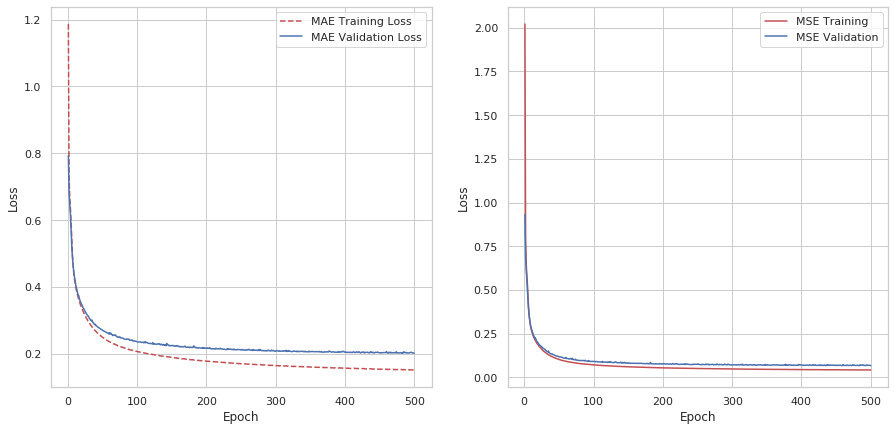

In [13]:
model = train_siamese(training_pairs=tr_pairs, 
              training_y=tr_y, 
              validation_pairs=val_pairs, 
              validation_y=val_y, 
              epochs=500, 
              batch_size=256, 
              learning_rate=0.0001,
              plot=True)

### (Or) Read model checkpoint

In [13]:
# stop here, change file

In [14]:
# #model_filename = "training/20191218_023743.h5"

# On LTS: "training/20200221_061000.h5"
# model_filename = "training/20200220_055622.h5" local, MSE as loss, 60K training
model_filename = "training/20200305_055207.h5" # local, MAE as loss, 60K training

In [15]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

### Some model results

In [16]:
from cryoem.distance_estimation import plot_results

In [17]:
y_tr_pred = model.predict_on_batch([tr_pairs[:256, 0], tr_pairs[:256, 1]])
y_val_pred = model.predict_on_batch([val_pairs[:256, 0], val_pairs[:256, 1]])

In [18]:
plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

--- Train Set ---
predicted: 2.3109419345855713
true:      2.23661732673645
mse:       0.005524147301912308
mae:       0.0743246078491211


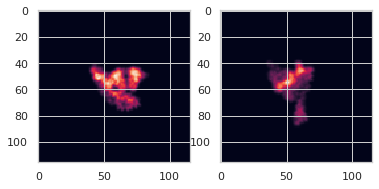

In [19]:
plot_train_results(1)

--- Validation Set ---
predicted: 2.5005996227264404
true:      2.2434768676757812
mse:       0.06611210852861404
mae:       0.2571227550506592


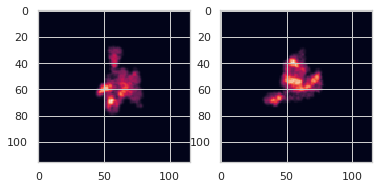

In [20]:
plot_validation_results(0)

---

## dP/dQ plot

In [23]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [44]:
def d_p(p1, p2):
    p1 = tf.convert_to_tensor(p1)
    p1 = tf.expand_dims(p1, len(p1.shape)) 
    p2 = tf.convert_to_tensor(p2)
    p2 = tf.expand_dims(p2, len(p2.shape))   #p2 = p2.reshape(list(p2.shape) + [-1]) 
    d = model.predict_on_batch([p1, p2])
    d = tf.cast(d, dtype=tf.float64)
    return d

In [45]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=256))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=256))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).numpy().T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

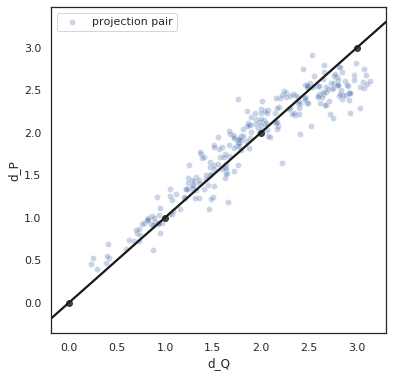

In [46]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

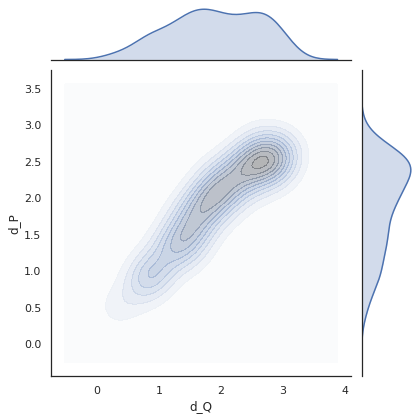

In [47]:
plot_dP_dQ_density(dP_values, dQ_values)

In [48]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.23076854872192537

# 2. Angle Recovery

In [29]:
from cryoem.angle_recovery import train_angle_recovery

###### Predicted Angles (initialization)

In [30]:
# angle_shift = [0.0, 0.0, 0.0]
# angle_coverage = [2.0, 0.4, 2.0]

# low_ang = [x*np.pi for x in angle_shift]
# high_ang = [x*np.pi for x in angle_coverage]

# euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
#                           high=[high_ang[0], high_ang[1], high_ang[2]],
#                           size=(len(angles_true), 3))

# # angles_predicted = [tf.Variable(e, constraint=lambda x: mod_angles(x, angle_shift, angle_coverage)) for e in euler]
# angles_predicted = [tf.Variable(e, dtype=tf.float32) for e in euler]


# angles_predicted = np.array(angles_predicted)
# angles_predicted.shape

In [31]:
# plot_angles_count(angles_predicted)

## Angle Recovery

Perfect distances. Learning rate 0.01

In [32]:
from cryoem.angle_recovery import train_angle_recovery

In [49]:
X = tf.cast(X, dtype=tf.float64)

In [72]:
# QUATERNION VARIABLE
import time
import numpy as np
from IPython import display as IPyDisplay
from tensorflow.keras.optimizers import Adam
import seaborn as sns; sns.set(style="white", color_codes=True)
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
import matplotlib.pyplot as plt

def train_angle_recovery(steps, batch_size, projection_idx, 
                        in_data, distance_fn, angles_predicted=None,
                        learning_rate=0.01, 
                        optimization=False): 
    time_start = time.time()
    
    optimizer = Adam(learning_rate=learning_rate)
    
    low_ang = [0.0*np.pi, 0.0*np.pi, 0.0*np.pi]
    high_ang = [2.0*np.pi, 0.4*np.pi, 2.0*np.pi]            
    euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(in_data), 3))
    q_predicted = [tf.Variable(q) for q in euler2quaternion(euler)]
#     q_predicted = [tf.Variable(tf.cast(quaternion.normalized_random_uniform((1,)), dtype=tf.float64)) for _ in range(len(in_data))]
    
    if in_data.shape[1] == 3:
        in_data = euler2quaternion(in_data)
    
    losses = np.empty(steps)
    report = ""
    found_minimizer = False
    
    print(time.time()-time_start)
    
    for step, idx1, idx2 in sample_iter(steps, projection_idx, batch_size, style="random"):
        #q_predicted = quaternion.normalize(q_predicted)
        q1 = [q_predicted[i] for i in idx1]
        q2 = [q_predicted[i] for i in idx2]

        # Compute distances
        in1 = [in_data[i] for i in idx1]
        in2 = [in_data[i] for i in idx2]
        
        distance_target = distance_fn(in1, in2)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(q1, q2, distance_target)
            optimizer.apply_gradients(zip(gradients, q1 + q2))
            
            # Visualize progress periodically
            if step % 10 == 0:
                plt.close();
                sns.set(style="white", color_codes=True)
                sns.set(style="whitegrid")

                fig, axs = plt.subplots(figsize=(10,7))

                # Optimization loss subplot
                axs.plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs.set_xlabel('time [s]')
                axs.set_ylabel('loss');
                axs.set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

                # T - Distance count subplot (full)
                #d2 = d_q(in_data, q_predicted)
                #axs[1].set_xlim(0, np.pi)
                #axs[1].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                #s = sns.distplot(d2, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
                #max_count = int(max([h.get_height() for h in s.patches]))
                #axs[1].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
                
                # NT - Distance count subplot (full)
                #q_predicted_T = euler2quaternion(quaternion2euler(q_predicted, transposed=True))
                #d2 = d_q(in_data, q_predicted_T)
                #axs[2].set_xlim(0, np.pi)
                #axs[2].set_title(f"FULL: [{step}/{steps}] TRANSPOSED Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                #s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
                #max_count = int(max([h.get_height() for h in s.patches]))
                #axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                IPyDisplay.clear_output(wait=True)
                IPyDisplay.display(plt.gcf())
                plt.close();
                time.sleep(1.0)
                
                if found_minimizer:
                    break;
        else:
            losses[step-1] = loss(a1, a2, distance_target)
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'
            
        if step >= 1001 and np.mean(losses[step-1001:step-1]) < 1e-8:
            found_minimizer = True
            
        if step >= 2001 and np.abs(np.mean(losses[step-1000:step-1])-np.mean(losses[step-2000:step-1000])) < 1e-7:
            found_minimizer = True
            
    print(report)
    return quaternion.normalize(q_predicted), losses
        
def sample_iter(steps, projection_idx, num_pairs, style="random", k=None):

    for step in range(1, steps+1):
        if not k and style != "random":
            raise ValueError("Please specify k for kNN for sample_pairs method")
        
        if style=="random":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            idx2 = list(np.random.choice(projection_idx, size=num_pairs))
        
        elif style=="knn":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
    
        elif style=="knn_and_random":
            # select random sample for the first element of pair
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            
            # half from kNN
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
            idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
            # half random
            idx2 = idx2_knn + idx2_random
        
        yield step, idx1, idx2
        
def loss(q1_predicted, q2_predicted, distance_target):
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean(tf.pow((d_q(q1_predicted, q2_predicted) - distance_target), 2))

def gradient(q1_predicted, q2_predicted, distance_target):
    with tf.GradientTape() as tape:
        loss_value = loss(q1_predicted, q2_predicted, distance_target)
        gradient = tape.gradient(loss_value, q1_predicted + q2_predicted)
        
    return loss_value, gradient

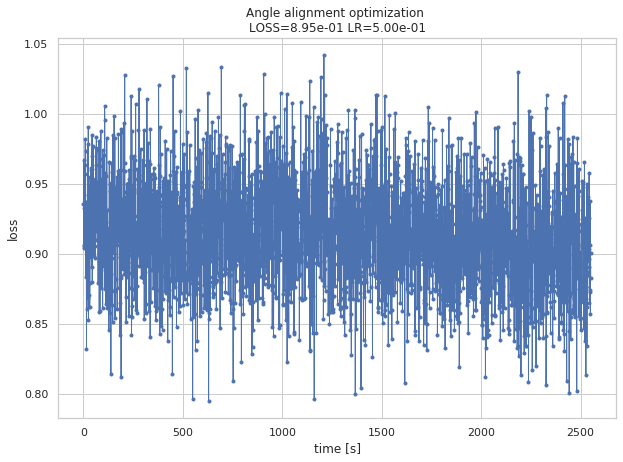

In [ ]:
# train_angle_recovery(steps=300000, 
#                      batch_size=256, 
#                      projection_idx=test_idx, 
#                      angles_predicted=angles_predicted, 
#                      est_dist_input=X, 
#                      est_dist=d_p, 
#                      learning_rate=0.01, 
#                      optimization=True)
q_predicted, losses = train_angle_recovery(steps=30000, 
                                 batch_size=512, 
                                 projection_idx=range(NUM_PROJECTIONS), 
                                 in_data=X, 
                                 distance_fn=d_p, 
                                 learning_rate=0.5, #0.1, 
                                 optimization=True)

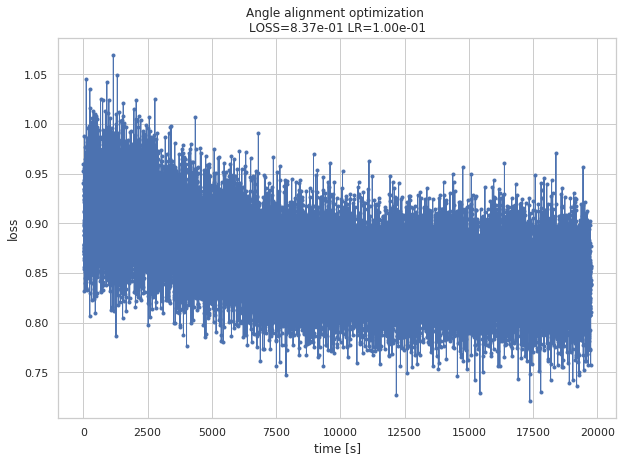

step 3000/30000 (2696s): loss = 9.29e-01
step 6000/30000 (5378s): loss = 8.97e-01
step 9000/30000 (8072s): loss = 8.38e-01
step 12000/30000 (10770s): loss = 8.18e-01
step 15000/30000 (13478s): loss = 8.47e-01
step 18000/30000 (16197s): loss = 8.35e-01
step 21000/30000 (18924s): loss = 8.26e-01



In [53]:
# train_angle_recovery(steps=300000, 
#                      batch_size=256, 
#                      projection_idx=test_idx, 
#                      angles_predicted=angles_predicted, 
#                      est_dist_input=X, 
#                      est_dist=d_p, 
#                      learning_rate=0.01, 
#                      optimization=True)
q_predicted = train_angle_recovery(steps=30000, 
                                 batch_size=512, 
                                 projection_idx=range(NUM_PROJECTIONS), 
                                 in_data=X, 
                                 distance_fn=d_p, 
                                 learning_rate=0.1, 
                                 optimization=True)

In [55]:
q_save = np.zeros((len(q_predicted),4))
for i, q in enumerate(q_predicted):
    q_save[i] = q.numpy()
                    
np.save("data/5j0n/predicted_quaternions_siamese.npy", q_save)

## Angle Alignment

In [68]:
qp = np.load("data/5j0n/predicted_quaternions_siamese.npy")

transposed = True
ap = quaternion2euler(qp, transposed=transposed)

np.save("data/5j0n/predicted_angles_siamese.npy", ap)

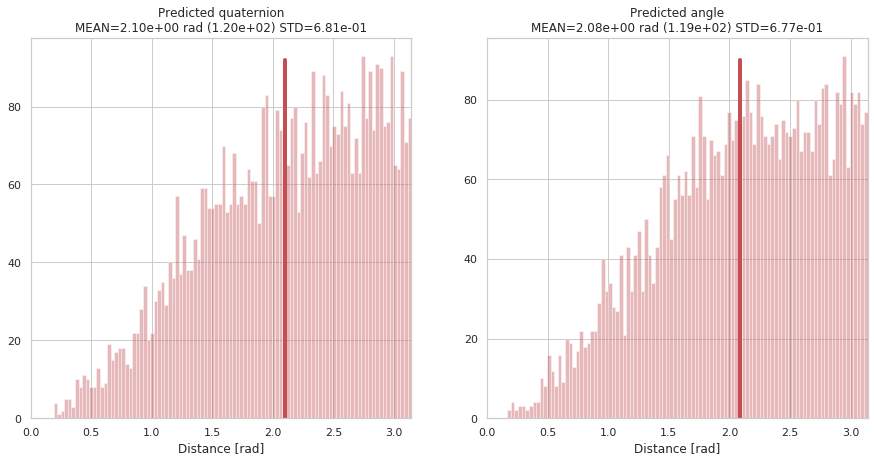

In [69]:
# check: both plots should be the same (if transposed=False)
fig, axs = plt.subplots(1, 2, figsize=(15,7))
d2 = d_q(euler2quaternion(angles_true), qp)
axs[0].set_xlim(0, np.pi)
axs[0].set_title(f"Predicted quaternion\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
s = sns.distplot(d2, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[0].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

d3 = d_q(euler2quaternion(angles_true), euler2quaternion(ap))
axs[1].set_xlim(0, np.pi)
axs[1].set_title(f"Predicted angle\nMEAN={np.mean(d3):.2e} rad ({np.degrees(np.mean(d3)):.2e}) STD={np.std(d3):.2e}")
s = sns.distplot(d3, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[1].plot([np.mean(d3)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

In [70]:
from cryoem.angle_alignment import training_angle_alignment

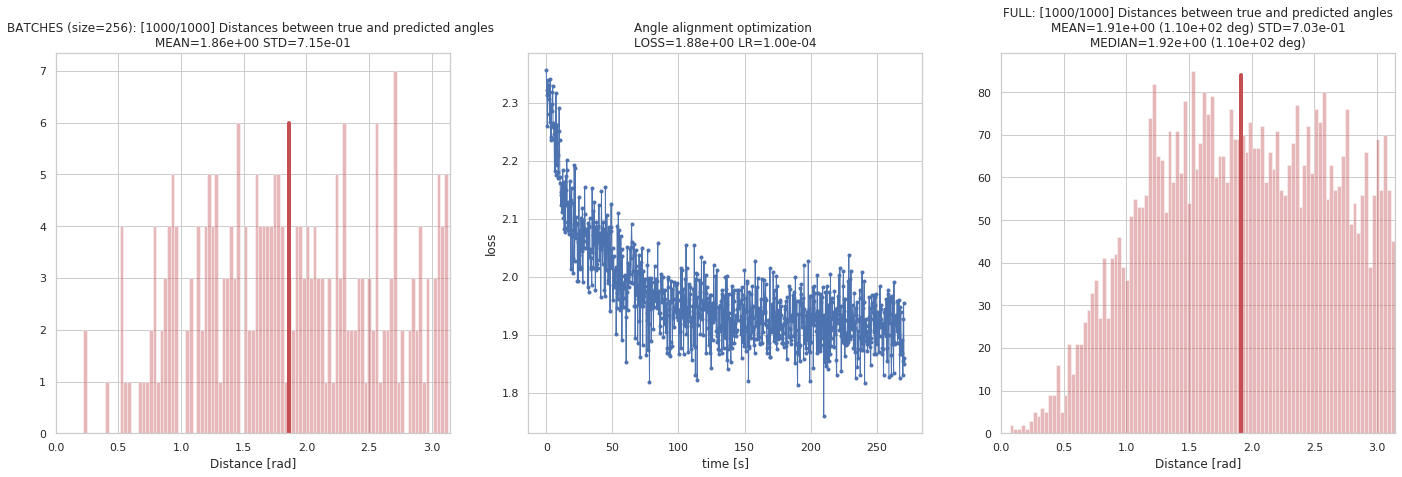

step 100/1000 (28s): loss = 2.16e+00
step 200/1000 (54s): loss = 2.05e+00
step 300/1000 (82s): loss = 1.98e+00
step 400/1000 (109s): loss = 1.95e+00
step 500/1000 (136s): loss = 1.94e+00
step 600/1000 (164s): loss = 1.93e+00
step 700/1000 (191s): loss = 1.92e+00
step 800/1000 (218s): loss = 1.92e+00
step 900/1000 (246s): loss = 1.92e+00
step 1000/1000 (273s): loss = 1.91e+00



In [71]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=1000, 
                                             batch_size=256, 
                                             projection_idx=range(NUM_PROJECTIONS), 
                                             learning_rate=0.01, 
                                             angles_true=angles_true, 
                                             angles_predicted=ap)

In [49]:
m, rotation[0].numpy(), loss

([1.0, 1.0, 1.0, 1.0],
 array([ 4.40194202,  2.462735  ,  6.17907471,  3.09036191,  6.38943444,
        -0.0428592 ]),
 0.002115659545205087)

In [50]:
qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qp)

transposed = False
angles_predicted = quaternion2euler(qpa, transposed=transposed).numpy()

np.save("data/5j0n/predicted_angles_siamese_updated.npy", angles_predicted)

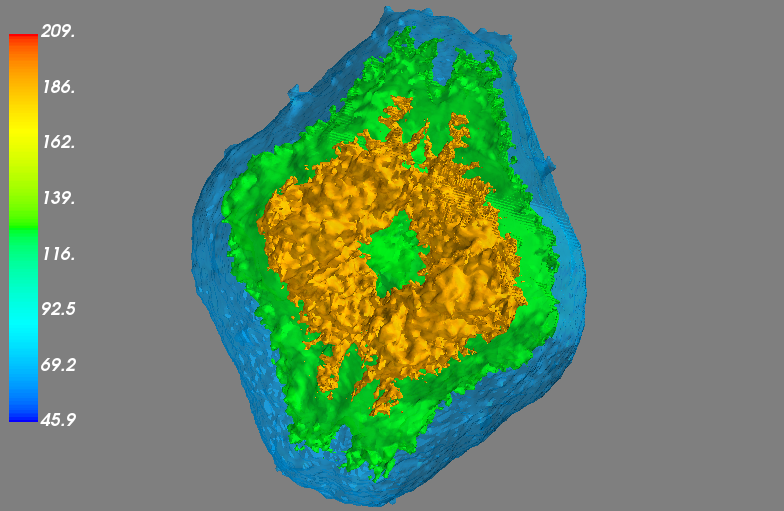

In [54]:
Image(filename='../3-reconstruction/data/5a1a_projections_and_angles_predicted_updated.png')

---

In [35]:

#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles_siamese1_Xnorm.npy")

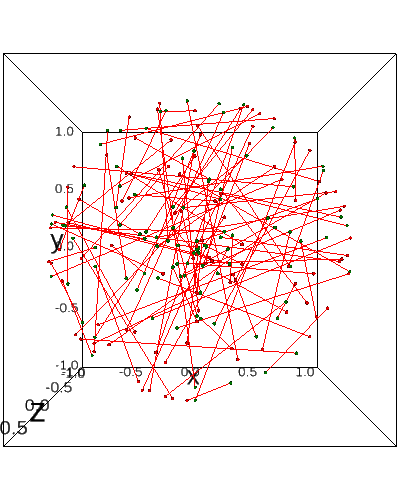

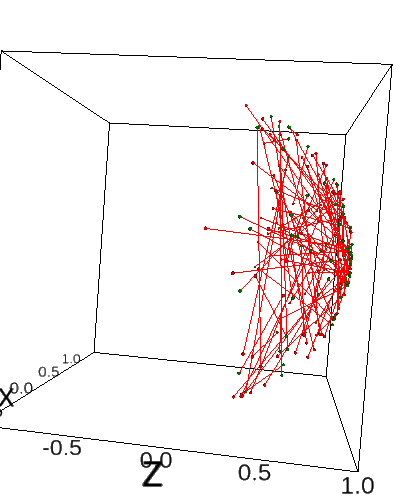

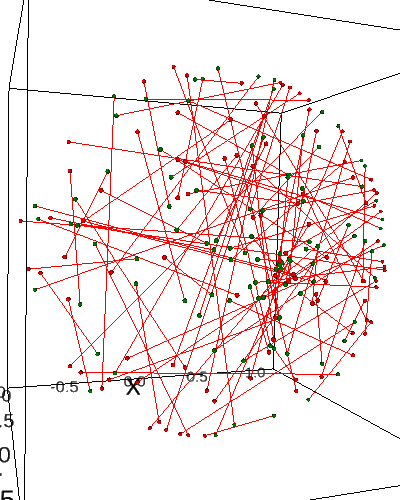

In [36]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [39]:
display(ipv.screenshot())

Output()

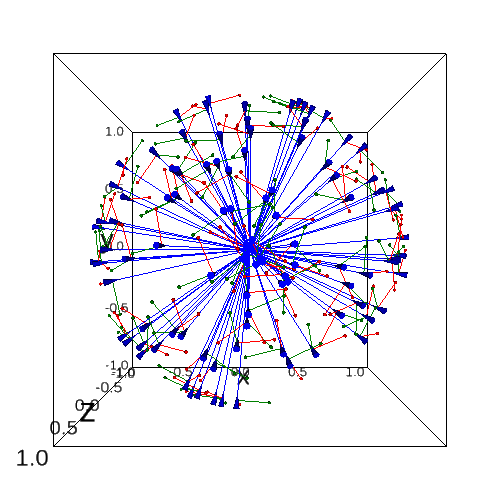

In [40]:
plot_rays(ap, indices=range(100))

In [41]:
display(ipv.screenshot())

Output()

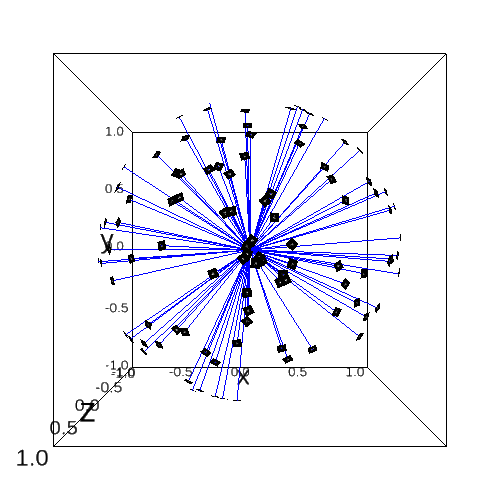

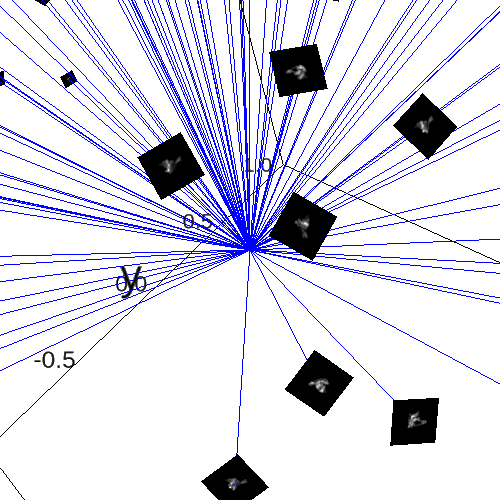

In [45]:
plot_images(ap, data['Projections'], indices=range(100),img_size_scale=0.05)

In [47]:
display(ipv.screenshot())

Output()

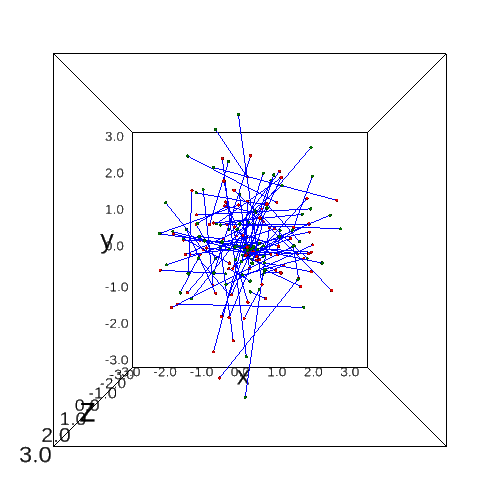

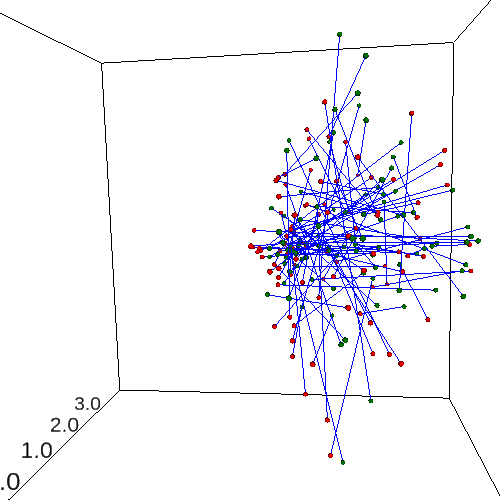

In [48]:
plot_selected_angles_with_3rd_angle_magnitude(ap, angles_true, range(100))

In [50]:
display(ipv.screenshot())

Output()

### Alignment

### Angle Alignment

In [12]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, updateR_alignment

#### Quaternion Alignment

In [13]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.8753162350501303
Geodesic distance:  0.9354977009682132  rad ( 53.60007000967016  degrees)
Quaternion distance:  1.8792453646910081


(0.8753162350501303, 0.9354977009682132, 1.8792453646910081)

FLIPPING: (1, 1, 1)
step 300/3000 (20s): loss = 1.89e+00
step 600/3000 (42s): loss = 1.86e+00
step 900/3000 (62s): loss = 1.84e+00
step 1200/3000 (83s): loss = 1.92e+00
step 1500/3000 (104s): loss = 1.85e+00
step 1800/3000 (125s): loss = 1.92e+00
step 2100/3000 (146s): loss = 1.82e+00
step 2400/3000 (167s): loss = 1.84e+00
step 2700/3000 (188s): loss = 1.85e+00
step 3000/3000 (208s): loss = 1.84e+00
Rotation: [-0.00490297 -0.02711936  0.1426672 ];  Loss: 1.8367986426233545
FLIPPING: (1, 1, -1)
step 300/3000 (21s): loss = 1.90e+00
step 600/3000 (43s): loss = 1.85e+00
step 900/3000 (65s): loss = 1.95e+00
step 1200/3000 (87s): loss = 1.85e+00
step 1500/3000 (110s): loss = 1.86e+00
step 1800/3000 (133s): loss = 1.80e+00
step 2100/3000 (155s): loss = 1.92e+00
step 2400/3000 (177s): loss = 1.84e+00
step 2700/3000 (201s): loss = 1.89e+00
step 3000/3000 (223s): loss = 1.84e+00
Rotation: [ 1.04681434 -0.00745438  1.07037117];  Loss: 1.8383151868526857
FLIPPING: (1, -1, 1)
step 300/3000 (24s): l

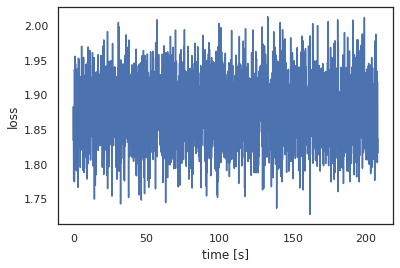

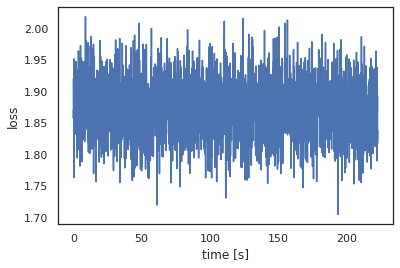

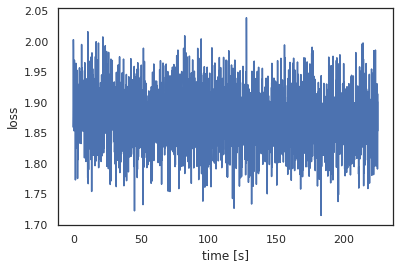

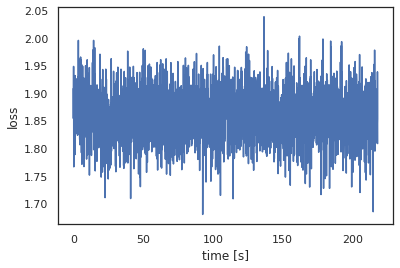

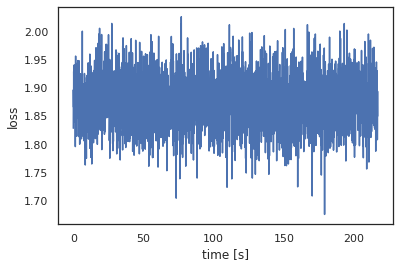

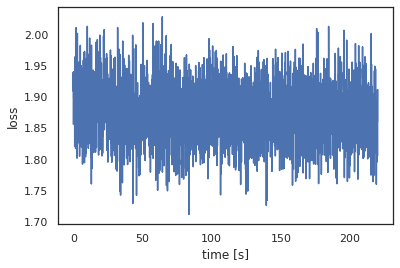

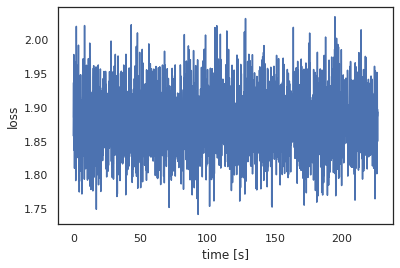

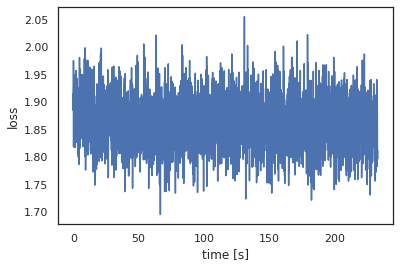

In [14]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=3000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [15]:
flips, a_R, loss

((-1, 1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([1.13859976, 0.00403881, 1.17981399])>],
 1.805538792924037)

In [16]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [17]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.8891816409860227
Geodesic distance:  0.9527709741869989  rad ( 54.58975566348293  degrees)
Quaternion distance:  1.8733542515433756


(0.8891816409860227, 0.9527709741869989, 1.8733542515433756)

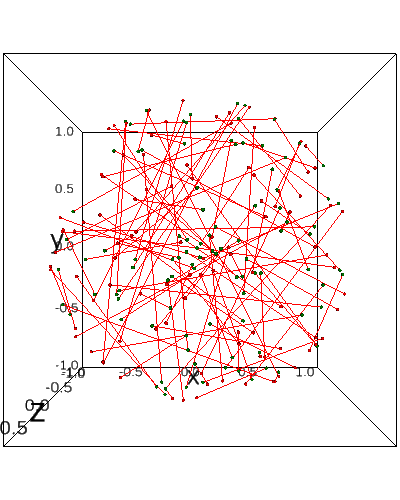

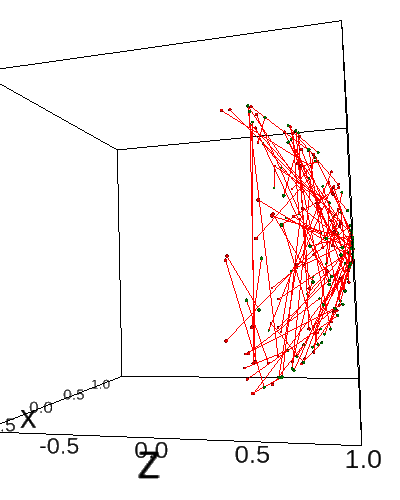

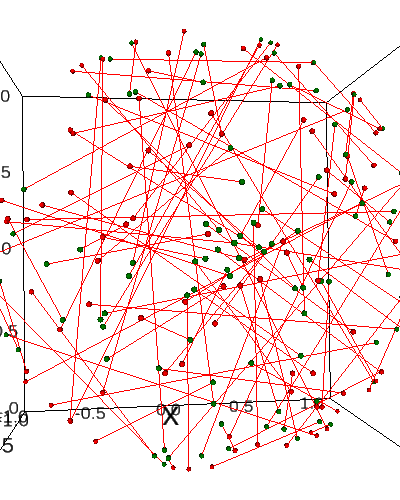

In [19]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [22]:
import ipyvolume as ipv

display(ipv.screenshot())

Output()

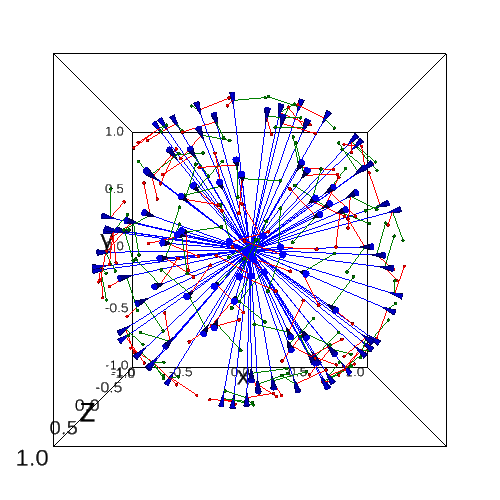

In [23]:
plot_rays(angles_predicted_new, range(100))

In [24]:
display(ipv.screenshot())

Output()

In [25]:
projections = data["Projections"]

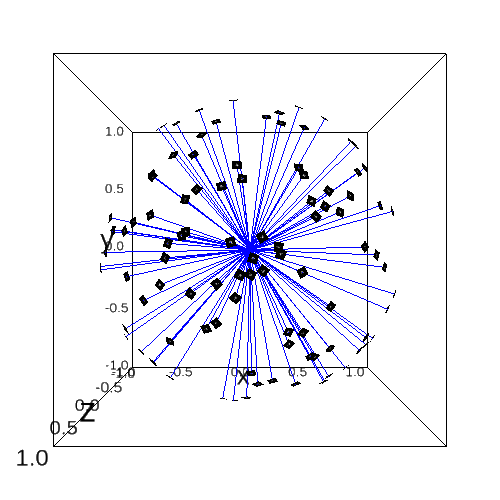

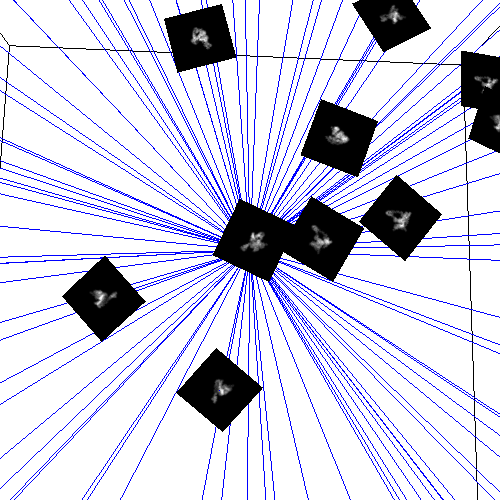

In [26]:
from cryoem.plots import plot_images
plot_images(angles_predicted_new, projections, indices=range(100),img_size_scale=0.05)

In [28]:
display(ipv.screenshot())

Output()

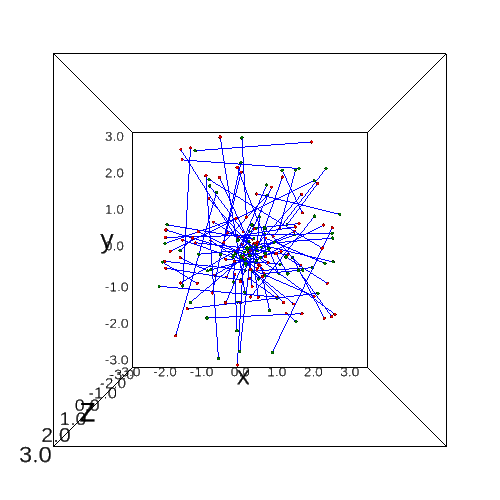

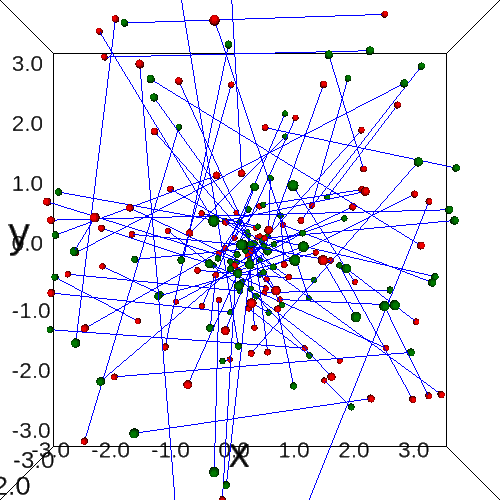

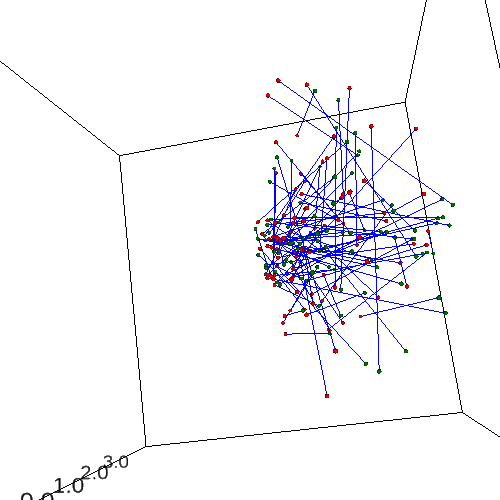

In [29]:
from cryoem.plots import plot_selected_angles_with_3rd_angle_magnitude

plot_selected_angles_with_3rd_angle_magnitude(angles_predicted_new, angles_true, range(100))

In [32]:
display(ipv.screenshot())

Output()